# Problem Set 2 - Decision Trees and Ensemble Methods
## CSCI 4622 - Fall 2024

***
**Name**: $<$Abdullah Yassine$>$
***

This assignment is due on Canvas by **11:59PM on October 2nd**.

Submit only this Jupyter notebook to Canvas. Do not compress it using tar, rar, zip, etc.
Your solutions to analysis questions should be done in Markdown directly below the associated question.

Remember that you are encouraged to discuss the problems with your classmates and instructors,
but **you must write all code and solutions on your own**, and list any people or sources consulted.
The only exception to this rule is that you may copy code directly from your own solution to homework 1 or labs.


## Overview

Your task for this homework is to build a decision tree classifier from scratch. Of course, we provide some initial classes that you'll be editing.
Since the other two problems will use the scikit-learn's DecisionTreeClassifier, your solution does not have to be efficient as long as it passes the sanity checks in a reasonable time (typically less than ~1min).

The last problem requires a _weak learner_, so we'll use a decision tree that yields low performance. But with _Ensemble Methods_, we will be able to improve the performance by aggregating predictions from multiple weak learners.
For the ensemble methods, we'll explore bagging, Random Forest, and boosting (AdaBoost).

Any Machine Learning interview will almost certainly have a question or two about decision trees and how they're trained.
So understanding the code and trying to implement everything on your own will be the best way to prepare for such interviews.

Also remember, if your code is correct then the sanity checks should pass without any major issue.
But if the sanity checks pass that does not necessarily imply your code is 100% correct.

Happy coding!

In [ ]:
from google.colab import drive
import sys
import os
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/HW2_Base') #all i had to do is do this
os.chdir('/content/drive/MyDrive/HW2_Base')

Mounted at /content/drive


In [129]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import helpers
%matplotlib inline

## Problem 1 - Decision Trees [50 points + 4 points]
***
The goal of this problem is to implement the core elements of the Decision Tree classifier.
We do not expect a highly efficient implementation of the functions since we will be using the implementation from scikit-learn in later problems.

We'll be testing our implementation on a simple toy dataset:

|Age|Income|Single| Has Pets | College Degree|
|:------:|:-----------:| :----------:| :----------:|:--:|
|20| 37000| 1| 0|0|
|32| 50000| 0| 0|0|
|24| 46000| 1| 1|0|
|28| 52000| 1| 1|1|
|28| 28000| 0| 1|0|
|22| 54000| 0| 1|1|
|28| 50000| 0| 0|1|
|26| 36000| 0| 0|1|
|24| 45000| 1| 1|0|
|33| 45000| 0| 0|1|
|34| 50000| 1| 1|0|
|29| 51000| 1| 0|1|

In [130]:
features = np.array([[20, 37000, 1, 0],
                     [32, 50000, 0, 0],
                     [24, 46000, 1, 1],
                     [28, 52000, 1, 1],
                     [28, 28000, 0, 1],
                     [22, 54000, 0, 1],
                     [28, 50000, 0, 0],
                     [26, 36000, 0, 0],
                     [24, 45000, 1, 1],
                     [33, 45000, 0, 0],
                     [34, 50000, 1, 1],
                     [29, 51000, 1, 0]])
labels = np.array([0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1])


### Computing Node Labels
Each leaf node (terminal node) in a decision tree has a label value assigned to it. The same label will be assigned to all samples that reach the leaf node during the prediction.

**Q1.1** [5 points] Complete `compute_label` to return the label that should be assigned to the leaf node based on training labels in `y`.
If more than one label are possible, choose the one with the highest value (e.g, if both `0` and `1` are equally likely, choose `1`)

In [131]:
def compute_label(node_labels):

    # Workspace 1.1
    # TODO: Return the label that should be assigned to the leaf node
    # In case of multiple possible labels, choose the one with the highest value
    # Make no assumptions about the number of class labels
    label = None
    #BEGIN
    negative_if_any = False
    node_labels_negative = []
    node_labels_positive = []
    act_max_negative = 0


    for i in range(len(node_labels)):
        if node_labels[i] < 0:
            negative_if_any = True
            node_labels_negative.append(abs(node_labels[i]))
        else:
            node_labels_positive.append(node_labels[i])



    if negative_if_any:
        most_common_negative = np.bincount(node_labels_negative)
        max_negative = most_common_negative.argmax()
        act_max_negative = max_negative
        if (len(most_common_negative) == 1) and (len(node_labels) == 1):
            label = node_labels[0] * -1
            return label

        for i in range(len(most_common_negative)):
            if most_common_negative[i] == most_common_negative[max_negative]:
                act_max_negative = i
                break





    most_common = np.bincount(node_labels_positive)
    max = most_common.argmax()
    act_max = max
    if len(most_common) == 1 and len(node_labels) == 1:
        label = node_labels[0]
    else:
        for i in range(len(most_common)):
            if most_common[i] == most_common[max]:
                act_max = i

        if negative_if_any:
            if(most_common_negative[act_max_negative] > most_common[act_max]):
                label = act_max_negative * -1
            else:
                label = act_max
        else:
            label = act_max




    #END
    return label

We provide below the LeafNode implementation

In [132]:
class LeafNode:
    def __init__(self, node_labels):
        """ Initialize the leaf node
        Args:
            y: 1-d array containing labels, of shape (num_points,)
        """
        self.label = compute_label(node_labels)

    @staticmethod
    def is_terminal():
        return True

    def predict(self, X):
        return self.label * np.ones(X.shape[0])

In [133]:
%run -i tests leaf

.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


<Figure size 640x480 with 0 Axes>

### Quantifying impurity
The tree also contains _decision nodes_. They can either be parents of: leaf nodes, decision nodes, or a combination of the two.

Each decision node has a left and a right child. A node is branched out (parent node) **when we can reduce the impurity** by splitting
the training instances based on a certain threshold.

First, we'll need to choose a impurity measure. For this problem, we will use the _gini impurity_ (information entropy is also commonly used here, which computes *uncertainty*).

\begin{align}
\text{Gini}(y) = 1 - \sum_{c=1}^{n} p_{c}^2
\end{align}

where $p_c$ is the probability of the occurrence of class $c$ among the $n$ labels in $y$

**Q1.2** [5 points] Complete the function `gini` that returns the gini impurity of labels in `y`.


In [134]:
def gini(y):
    """
    Args:
        y: 1-d array contains labels, of shape (num_points,)
    Returns: float, gini impurity of the values in y
    """
    gini = 0
    # Workspace 1.2
    # TODO: Compute the gini impurity of the labels
    #BEGIN
    counts = np.unique(y, return_counts=True)[1]
    counts = counts / len(y)
    gini = 1 - np.sum(counts ** 2)

    #END
    return gini

In [135]:
# Test cell, uncomment to run the tests
%run -i tests gini

.
----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


When we create a decision node, we decide to split our samples $T$ to two parts $T_L$ and $T_R$, and we want to compute how much this split reduces the impurity.

**Q1.3** [5 points] Using the impurity measure $\mathcal{u}$, what is the expression of the expected impurity reduction if we split $T$ into $T_L, T_R$ ?

You can use LaTeX markdown to [type the equations](https://www.fabriziomusacchio.com/blog/2021-08-10-How_to_use_LaTeX_in_Markdown/)

##### Workspace 1.3

#BEGIN
So, we will need to find the impurity of each of the splits, add them together, and subtract them from the whole data set impurity. However, before we add them together, we must weigh them and multiply the split individual impurities based on the length of the split over the length of the sample:

$$\text{weighted impurity of } u(T_{L}) = \frac{\left| T_{L} \right|}{\left| T \right|} \cdot u(T_{L})$$

$$\text{weighted impurity of } u(T_{R}) = \frac{\left| T_{R} \right|}{\left| T \right|} \cdot u(T_{R})$$

Therefore, now we can add those weighted impurities and then we can subtract them from the sample impurity to get the expected impurity reduction.

$$\Delta u = u(T) - (\frac{\left| T_{L} \right|}{\left| T \right|} \cdot u(T_{L}) + \frac{\left| T_{R} \right|}{\left| T \right|} \cdot u(T_{R}))$$


#END


Note: If we were to use entropy as our uncertainty measure, the uncertainty reduction in this case is also called _information gain_.
(reducing the entropy implies that the partitioning decision variable and the labels have a higher mutual information).

Instead, we use gini impurity, which reduces the cluster impurity, and is faster to compute than entropy.

**Q1.4** [5 points] Complete the `impurity_reduction` function to return the reduction of the split using the gini impurity.

In [136]:
def impurity_reduction(y, left_indices, right_indices):
    """
    Args:
        y: all labels
        left_indices: the indices of the elements of y that belong to the left child
        right_indices: the indices of the elements of y that belong to the right child
    Returns: impurity reduction of the split
    """
    reduction = 0
    # Workspace 1.4
    #BEGIN
    reduction = gini(y) - (len(left_indices) / len(y) * gini(y[left_indices])) - (len(right_indices) / len(y) * gini(y[right_indices]))
    #END
    return reduction

In [137]:
# Test cell, uncomment to run the tests
%run -i tests reduction

.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


### Splitting data

We'll use `best_split` to look up for the feature and threshold that yields the partition with the best impurity reduction.

- For each feature:
    - Compute all possible thresholds (use `split_values`)
    - For each threshold:
        - Split to `(left_indices, right_indices)` based on the threshold
        - Compute the impurity reduction of the split
- Returns the feature and the threshold that yield the highest impurity reduction (and the reduction value)
<br>

**Q1.5** [8 points] Complete `best_split`. In case there are multiple possible solutions, return the first one encountered.

 _Hint: `split_values` is provided as a helper function. It takes the feature column and returns the set of thresholds. Use print to display the behavior if still not clear_

In [138]:
def split_values(feature_values):
    """ Helper function to return the split values. if feature consists of the values f1 < f2 < f3 then
    this returns [(f2 + f1)/2, (f3 + f2)/2]
    Args:
        feature_values: feature_values: 1-d array of shape (num_points)
    Returns:  array of shape (max(m-1, 1),) where m is the number of unique values in feature_values
    """
    unique_values = np.unique(feature_values)
    if unique_values.shape[0] == 1:
        return unique_values
    return (unique_values[1:] + unique_values[:-1]) / 2


def best_split(X, y):
    """ Find the feature id, threshold, indices, and reduction for the best split
    Args:
        X: features array, shape (num_samples, num_features)
        y: labels of instances in X, shape (num_samples)
    Returns: the best split related information.
    """

    best_feature_id, best_threshold, best_left_indices, best_right_indices = None, None, None, None
    best_reduction = -np.inf

    # Workspace 1.5
    # TODO: Complete the function as detailed in the question and return description
    # NOTE: See specification in Q1.6:
    #       if feature_value == threshold, it should end up in the **left** child.
    best_impurity = 0
    for feature_id in range(X.shape[1]):
        for threshold in split_values(X[:, feature_id]):
        #BEGIN
            left_indices = np.where(X[:, feature_id] <= threshold)[0]
            right_indices = np.where(X[:, feature_id] > threshold)[0]
            reduction = impurity_reduction(y, left_indices, right_indices)
            if(reduction > best_reduction):
                best_reduction = reduction
                best_feature_id = feature_id
                best_threshold = threshold
                best_left_indices = left_indices
                best_right_indices = right_indices
        #print(best_reduction
        #END
    return best_feature_id, best_threshold, best_left_indices, best_right_indices, best_reduction

In [139]:
# Test cell, uncomment to run the tests
# If you chose to not use split_values, then this test will likely fail
%run -i tests split

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


### Decision (non-leaf) nodes
Note that samples for which the `feature_id` value is <= `feature_threshold` will go into the `left_child`. We should construct our decision tree as such.
We define the DecisionNode class below.

- The `add_importance` method is relevant to Bonus Q1.10 later in this notebook.

In [140]:
class DecisionNode:
    def __init__(self, feature_id, threshold, left_child, right_child):
        self.feature_id = feature_id
        self.threshold = threshold
        self.left = left_child
        self.right = right_child

    @staticmethod
    def is_terminal():
        return False

    def add_importance(self, importances: dict, X, y):
        # Workspace 1.10
        # Bonus question
        # Note that dictionaries are passed by reference and not by value
        #BEGIN
        #END
        return importances

    def predict(self, X):
        y_pred = np.zeros((X.shape[0]))
        left_indices = np.where(X[:, self.feature_id] <= self.threshold)[0]
        right_indices = np.where(X[:, self.feature_id] > self.threshold)[0]
        y_pred[left_indices] = self.left.predict(X[left_indices])
        y_pred[right_indices] = self.right.predict(X[right_indices])
        return y_pred

### Putting nodes together: building the tree

Now we tackle the core of a decision tree. The tree is built in a recursive way. The recursion in `build_tree` works as follows:
- Parameters: `min_samples_split`, `depth`
- Inputs: `X`, `y`
- Base case of the recursion, return a leaf node if either:
    - `depth` is 0
    - `y` contains less than `min_samples_split` elements
    - There is no impurity reduction (reduction<=0 for all splits)
- Recursion (there is a split with reduction > 0):
    - create a decision node with left and right child nodes with `depth - 1`
    - return the decision node

The left child node will contain instances for which the feature with index `best_feature` is strictly <
`best_threshold` of the split. The right child takes the remaining instances.


**Q1.6** [10 points] Complete `build_tree` method


In [141]:
def build_tree(X, y, depth=-1, min_samples_split=2):
    if depth == 0 or len(y) < min_samples_split:
        # we reached the maximum depth or we don't have more than the minimum number of samples in the leaf
        tree = LeafNode(y)
    else:
        # Get the feature, threshold and information_gain of the best split
        feature_id, threshold, left_indices, right_indices, reduction = best_split(X, y)
        # reduction = 0 occurs when the labels have the same distribution in the child nodes
        # which means that the entropy of the children is the same as the parent's so we don't need to split
        # Workspace 1.6
        # TODO: if needed, create the left and right child nodes with depth - 1, return the decision node
        #BEGIN
        if reduction <= 0:
            tree = LeafNode(y)
        else:
            left_child = build_tree(X[left_indices], y[left_indices], depth - 1, min_samples_split)
            right_child = build_tree(X[right_indices], y[right_indices], depth - 1, min_samples_split)
            tree = DecisionNode(feature_id, threshold, left_child, right_child)

        #END
    return tree

**Q1.7** [4 points] Complete the `score` method that returns the accuracy on the given data (you can use `sklearn.metrics`)

In [142]:
class DecisionTree:

    def __init__(self, max_depth=-1, min_samples_split=2):
        """ Initialize the decision tree
        Args:
            max_depth: maximum depth of the tree
            min_samples_split: minimum number of samples required for a split
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
        self.num_features = None

    def fit(self, X, y):
        """
        Args:
            X: Training samples
            y: training labels
        Return:
             trained decision tree
        """
        self.tree = build_tree(X, y, self.max_depth, self.min_samples_split)
        return self

    def predict(self, X):
        """
        Loops through rows of X and predicts the labels one row at a time
        """
        return self.tree.predict(X)

    def feature_importance(self, X, y):
        """ Compute the importance of each feature in the decision tree
         Only relevant to the bonus question
        """
        feat_importance = {k:0 for k in range(X.shape[1])}
        if not self.tree.is_terminal():
            self.tree.add_importance(feat_importance, X, y)
        feat_importance = {k: v/sum(feat_importance.values()) for k,v in feat_importance.items()}
        return feat_importance

    def score(self, X, y):
        """ Return the mean accuracy on the given test data and labels.
        Args:
            X: Test samples, shape (num_points, num_features)
            y: true labels for X, shape (num_points,)
        Return:
            mean accuracy
        """
        accuracy = 0
        # Workspace 1.7
        #BEGIN
        prediction = self.predict(X)
        accuracy = np.mean(prediction == y)
        #END
        return accuracy

In [143]:
# Test cell, uncomment to run the tests
# If you chose to not use split_values, then this test will likely fail
%run -i tests build

.
----------------------------------------------------------------------
Ran 1 test in 0.010s

OK


**Q1.8** [4 points] Using `min_samples_split=2`, what is the minimum depth so that our `DecisionTree` fits perfectly our dataset `(features, labels)`.

In [144]:
# Workspace 1.8
# To show that the minimum required depth is n, you can provide the accuracy for depth = (n-1) and depth = n
#BEGIN

unique_labels = np.unique(labels)
min_samples_split = 2
depth = 0
while True:
    tree = DecisionTree(max_depth=depth, min_samples_split=min_samples_split).fit(features, labels)
    if tree.score(features, labels) == 1:
        break
    depth += 1

tree = DecisionTree(max_depth=depth - 1, min_samples_split=min_samples_split).fit(features, labels)
print("Accuracy on training set:", tree.score(features, labels))

tree = DecisionTree(max_depth=depth, min_samples_split=min_samples_split).fit(features, labels)
print("Accuracy on training set:", tree.score(features, labels)) #depth is 5





#END

Accuracy on training set: 0.9166666666666666
Accuracy on training set: 1.0


We provide an example below to display the structure of a decision tree.

**Q1.9** (4points) Edit the example below to show the tree for the required minimum depth found in 1.8

In [145]:
tree = DecisionTree(max_depth=3, min_samples_split=2).fit(features, labels)
helpers.print_tree(tree, ["age", "income", "single", "has_pets"])
#BEGIN
tree= DecisionTree(max_depth=5, min_samples_split=2).fit(features, labels)
helpers.print_tree(tree, ["age", "income", "single", "has_pets"])

#END

                              ┌│label: 0
                   ┌|income  │L
                   │|32000.00│R
                   │          └│label: 1
          ┌|single│L
          │|0.50  │R
          │        └│label: 0
|income  │L
|50500.00│R
          └│label: 1
                              ┌│label: 0
                   ┌|income  │L
                   │|32000.00│R
                   │          │       ┌│label: 1
                   │          └|age  │L
                   │           |30.00│R
                   │                  │       ┌│label: 0
                   │                  └|age  │L
                   │                   |32.50│R
                   │                          └│label: 1
          ┌|single│L
          │|0.50  │R
          │        └│label: 0
|income  │L
|50500.00│R
          └│label: 1


#### Bonus
Now we can be a bit more ambitious and compute the importance of each feature in our decision tree. The importance of feature $f$
is the sum of the weighted impurity reduction of decision nodes that are split based on the feature $f$.

The weighted impurity reduction of $node_i$ is the following:

\begin{align}
\frac{N_{\text{node}_i}}{N_\text{total}} \times \textrm{Reduction}({\text{node}_i}),
\end{align}

where $N$ is the total number of training samples, and $N_{\text{node}_i}$ is the number of training samples that reach the decision node $node_i$.

Since we scale the feature importances in `DecisionTree` to sum to 1, we don't have to divide by $N_\text{total}$
and we can simply use:

\begin{align}
\text{weighted reduction}(\text{node}_i) = N_{\text{node}_i} \times \textrm{Reduction}({\text{node}_i}),
\end{align}

Practically, we use a dictionary `feat_importance` that maps feature indices to their importances.
- Start with `feat_importance[f]=0` for all `f`
- Start the recursion from the root node:
    - Current node is split based on feature `i`
    - add weighted impurity reduction to `feat_importance[i]`
    - ask right and left child to do the same
- Scale the values in `feat_importance` to sum to 1
- return `feat_importance`


**(Bonus)Q1.10** [4 points] Complete `DecisionNode`'s `feature_importance`


In [146]:
# Uncomment to test
%run -i tests importance

E
ERROR: test_importance (__main__.TestDT)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/content/drive/MyDrive/HW2_Base/tests.py", line 99, in test_importance
    importance = tree.feature_importance(features, labels)
  File "<ipython-input-142-f07c2fc8d4e8>", line 38, in feature_importance
    feat_importance = {k: v/sum(feat_importance.values()) for k,v in feat_importance.items()}
  File "<ipython-input-142-f07c2fc8d4e8>", line 38, in <dictcomp>
    feat_importance = {k: v/sum(feat_importance.values()) for k,v in feat_importance.items()}
ZeroDivisionError: division by zero

----------------------------------------------------------------------
Ran 1 test in 0.010s

FAILED (errors=1)


## Problem 2 - Decision Tree Ensembles [50 points]
---


We've seen that a DecisionTreeClassifier with depth = 3 is far from being the best performing on our house prices data.

In this problem, we will introduce 3 ensemble methods to _boost_ the performance of this poor and underestimated weak learner.

First, we'll need a fancier dataset. We are going to predict house price levels using the decision trees.

We start by loading preprocessed data that we'll use. Since the original House Prices [dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) is for regression, we have to transform `HousePrices.y` to discrete values reflecting price level.

|Price range| Label|
|:----------:|--:|
| $ P < $125000|0|
|125000$\leq P < $ 160000| 1 |
|160000$ \leq P < $ 200000| 2 |
|200000$ \leq P $ | 3 |


**Q2.1** [4 points] Transform `house_prices.y` following the table above


In [149]:
import data

house_prices = data.HousePrices()
# Workspace 2.1
# TODO: Discretize house_prices.y
#BEGIN

for i in range(len(house_prices.y)):
  if house_prices.y[i] < 125000:
    house_prices.y[i] = 0
  elif house_prices.y[i] < 160000:
    house_prices.y[i] = 1
  elif house_prices.y[i] < 200000:
    house_prices.y[i] = 2
  else:
    house_prices.y[i] = 3
#END
print(np.unique(house_prices.y), house_prices.X.shape)

[0 1 2 3] (1458, 79)


In [150]:
%run -i tests discretize

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


In [151]:
tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=0.1).fit(house_prices.X, house_prices.y)
print("Accuracy on training set:", tree.score(house_prices.X, house_prices.y))

Accuracy on training set: 0.6625514403292181


The cell above show that even when evaluated on the training data, a decision tree of depth 3 does not perform well

Whenever we need to generate a new instance of our weak learner, we'll have to call `get_weak_leaner`.

In [152]:
def get_weak_learner():
    """Return a new instance of out chosen weak learner"""
    return DecisionTreeClassifier(max_depth=3, min_samples_leaf=0.1)

Start by completing the `Evaluator` class that we'll use to evaluate different ensemble methods.


**Q2.2** [6 points] Complete the `evaluate_model` class to fit the model that is passed in as an argument, and store the accuracy and running time.

Since we don't have a validation set, you have to use [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) (`self.k_fold`) to perform a 3-fold cross validation and store the weighted average precision over the 3 folds

You can use the function `plot_metrics` to show and compare different statistics of each model in a bar chart.



In [153]:
from time import time
from sklearn.model_selection import StratifiedKFold
import pandas as pd


class Evaluator:
    """
        Test multiple model performance
    """

    def __init__(self, dataset):
        """ Initialize Evaluator
        Args:
            dataset: dataset containing Training and Test sets
        """
        self.dataset = dataset
        self.execution_time = {}  # dictionary with key: model name, value: time taken to fit and score the model
        self.scores = {}  # dictionary with key: model name, value: weighted average precision
        self.score_name = 'WAP'
        # See: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
        self.k_fold = StratifiedKFold(3, shuffle=True, random_state=42)

    def evaluate_model(self, model, name):
        """ Fit the model using the training data and save the evaluation score on the test fold
        Args:
            model: classifier to evaluate, has fit and predict methods
            name: name of model
        """
        start = time()
        # Workspace 2.2
        # TODO: Fit the model on the 3 different folds and store the average accuracy in self.score[name]
        #BEGIN

        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = []
        for train_index, test_index in skf.split(self.dataset.X, self.dataset.y):
            X_train, X_test = self.dataset.X[train_index], self.dataset.X[test_index]
            y_train, y_test = self.dataset.y[train_index], self.dataset.y[test_index]
            model.fit(X_train, y_train)
            scores.append(model.score(X_test, y_test))
        self.scores[name] = np.mean(scores)

        #END
        self.execution_time[name] = time() - start

    def print_results(self):
        """
            print results for all models trained and tested.
        """
        models_cross = pd.DataFrame({
            'Model': list(self.scores.keys()),
            self.score_name: list(self.scores.values()),
            'Execution time': list(self.execution_time.values())})
        print(models_cross.sort_values(by=self.score_name, ascending=False))

    def plot_metrics(self):
        """
        Plot bar chart, one for each statistic (metric, score, running time)
        """
        fig, axs = plt.subplots(1, 2)
        fig.set_figheight(6), fig.set_figwidth(18)
        p = 0
        for stats, name in zip([self.scores, self.execution_time],
                               [self.score_name, "Elapsed time"]):
            left = [i for i in range(len(stats))]
            height = [stats[key] for key in stats]
            tick_label = [key for key in stats]
            axs[p].set_title(name)
            axs[p].bar(left, height, tick_label=tick_label, width=0.5)
            p += 1
        plt.show()

**Q2.3** [3 points] Test `Evaluator.evaluate_model` using our weak learner returned by `get_weak_learner`

          Model       WAP  Execution time
0  weak_learner  0.604252        0.025857


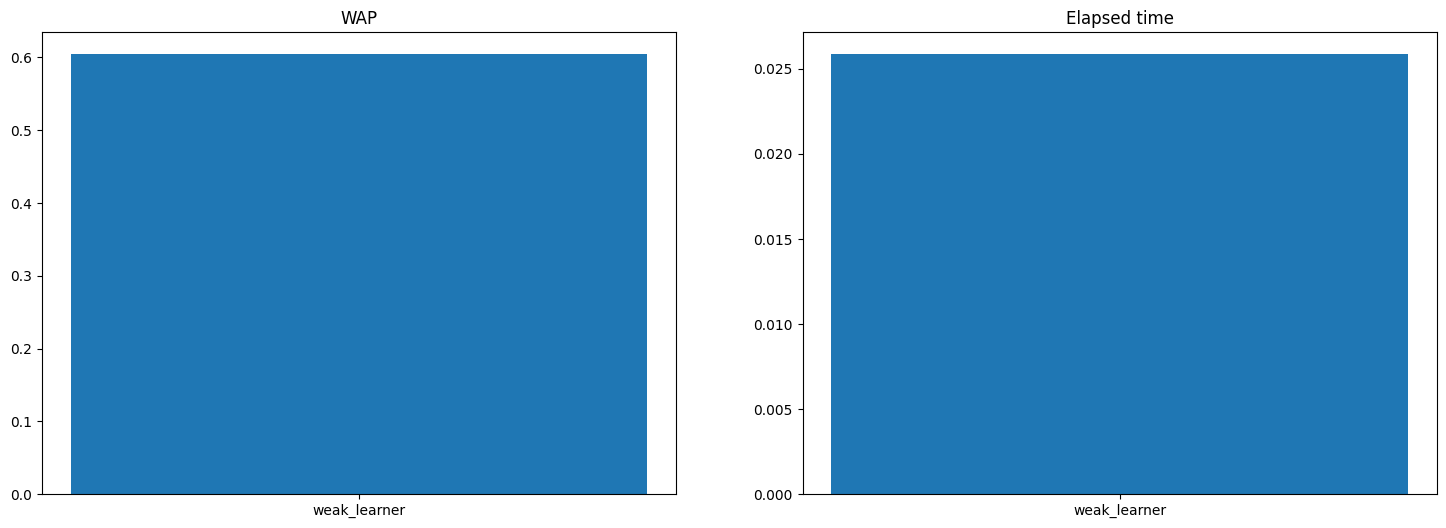

In [154]:
# create a handler for ensemble_test, use the created handler for fitting different models.
ensemble_handler = Evaluator(house_prices)
# Workspace 3.3
# TODO: Initialize weak learner and evaluate it using evaluate_model
#BEGIN
ensemble_handler.evaluate_model(get_weak_learner(), 'weak_learner')
#END
ensemble_handler.print_results()
ensemble_handler.plot_metrics()

**Bagging:**

The first Ensemble technique we deal with is called _Bagging_ (Bootstrap AGGregatING).
Bagging consists of training a number of weak learners using randomly sampled instances from our data (**with replacement**). We have to start
by choosing the number of estimators we want to use. Then for each estimator, we sample a random subset of the data to fit the estimator.

To compute the prediction, we sum the prediction probabilities of the estimators and return the label that has the highest
accumulated probabilities.

**Q2.4** [5 points] First, complete `sample_data` to return a random sample of size `sample_ratio * len(X_train)` of features and labels
    - *Hint*: see the numpy.random module.

**Q2.5** [6 points] Complete the `fit` method by instantiating `n_estimators` of our weak leaner, each trained on a random sample of the data

**Q2.6** [5 points] Complete the `predict` method to return the most likely label by combining the estimators predictions.

Instead of the majority vote used in KNNClassifier, you should use the `predict_proba` method of `DecisionTreeClassifier`.
[See Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba)

In [163]:
class BaggingEnsemble(object):

    def __init__(self, n_estimators, sample_ratio=1.0):
        """
        Initialize BaggingEnsemble
        :param n_estimators: number of estimators/weak learner to use
        :param sample_ratio: ratio of the training data to sample
        """
        self.n_estimators = n_estimators
        self.sample_ratio = sample_ratio
        self.estimators = []  # List used in fit method to store the trained estimators

    def sample_data(self, X_train, y_train):
        X_sample, y_sample = None, None
        # Workspace 2.4
        # TODO: sample random subset of size sample_ratio * len(X_train), sampling is with replacement (iid)
        #BEGIN
        indices = np.random.choice(len(X_train), int(self.sample_ratio * len(X_train)), replace=True)
        X_sample = X_train[indices]
        y_sample = y_train[indices]
        #END
        return X_sample, y_sample

    def fit(self, X_train, y_train):
        """
        Train the different estimators on sampled data using provided training samples
        :param X_train: training samples, shape (num_samples, num_features)
        :param y_train: training labels, shape (num_samples)
        :return: self
        """
        np.random.seed(42)  # Keep it to get consistent results across runs, you can change the seed value
        self.estimators = []

        for _ in range(self.n_estimators):
            # Workspace 2.5
            #BEGIN
            X_sample, y_sample = self.sample_data(X_train, y_train)
            estimator = get_weak_learner()
            estimator.fit(X_sample, y_sample)
            self.estimators.append(estimator)

            #END
        return self

    def predict(self, X_test):
        """
        Predict the labels of test samples
        :param X_test: array of shape (num_points, num_features)
        :return: 1-d array of shape (num_points)
        """
        predicted_proba = 0
        answer = 0
        # Workspace 2.6
        # TODO: go through the trained estimators and accumulate their predicted_proba to get the mostly likely label
        #BEGIN
        for estimator in self.estimators:
          predicted_proba += estimator.predict_proba(X_test) #soop
        answer = np.argmax(predicted_proba, axis=1)
        #END
        return answer

    def score(self, X, y):
        return np.mean(self.predict(X) == y)


          Model       WAP  Execution time
1       Bagging  0.661866        0.171732
0  weak_learner  0.604252        0.025857


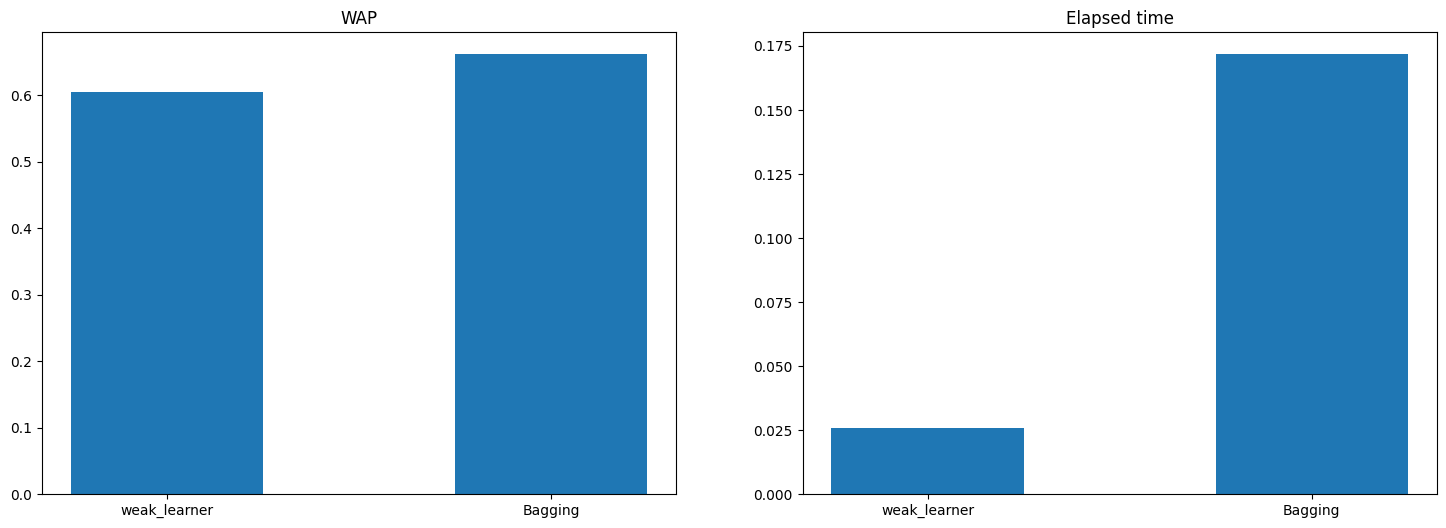

In [164]:
# This cell should run without errors
ensemble_handler.evaluate_model(BaggingEnsemble(10, 0.9), 'Bagging')
ensemble_handler.print_results()
ensemble_handler.plot_metrics()

### Random Forest

Random Forest has an additional layer of randomness compared to Bagging: we also project the dataset into a lower dimensional subspace.
The rest of the implementation should be similar if not exactly the same as Bagging. In addition to keeping track of the estimators, we also need to store the projection matrix associated with the estimator (since each estimator operates on a different subspace).

First, we have to generate the random subspaces that we will project into. We do so by generating a random orthonormal basis of the subspace as follows:
- Input space dimension n, subspace dimension m
- Generate a random normal `G` matrix of shape (n,m): entries have mean 0 and standard deviation 1
- Perform the reduced Q,R decomposition on `G` to get the orthonormal basis matrix `Q` of shape (m,n)

Then to project n features to m features, we right multiply by `Q`

**Q2.7** [5 points] First, complete `random_selection` to randomly sample a subset of the features (with replacement)

In [165]:
def random_selection(input_dim, output_dim):
    """ Randomly sample output_dim indices in range [0, input_dim-1]
    Returns:
        indices array of size (output_dim,)
    """
    assert input_dim >= output_dim
    # Workspace 2.7
    selected_features = None
    #BEGIN
    selected_features = np.random.choice(input_dim, output_dim, replace=True)

    #END
    return selected_features


**Q2.8** [3 points] Complete `sample_data` by defining the `input_dim`, `output_dim` for the random selection of features and the `indices` of the randomly picked samples (similar to bagging)

**Q2.9** [5 points] Complete `fit` by building `n_estimators` of DecisionTreeClassifier, each trained on random projection of the data.
Make sure to keep track of the projection matrix for each estimator to use them in the prediction step

**Q2.10** [4 points] Complete `predict` method to return the most likely label by combining different estimators predictions. Instead of the majority vote used in KNNClassifier, you should use `predict_proba` method DecisionTreeClassifier:
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba)


In [220]:
class RandomForest(BaggingEnsemble):

    def __init__(self, n_estimators, sample_ratio=1.0, features_ratio=1.0):
        super(RandomForest, self).__init__(n_estimators, sample_ratio)
        self.features_ratio = features_ratio
        self.estimators = []  # to store the estimator
        self.selections = []  # to store the feature indices used by each estimator

    def sample_data(self, X_train, y_train):

        input_dim = None
        output_dim = None
        indices = None
        # Workspace 2.8
        #BEGIN
        #input_dim = X_train.shape[1]

        input_dim = X_train.shape[1]
        output_dim = int(self.features_ratio * input_dim)
        indices = np.random.choice(X_train.shape[0], size=int(self.sample_ratio * X_train.shape[0]), replace=True)



        #END
        selected_features = random_selection(input_dim, output_dim)
        return X_train[indices][:, selected_features], y_train[indices], selected_features

    def fit(self, X_train, y_train):
        # np.random.seed(42)  # keep to have consistent results across run, you can change the value
        self.estimators = []  # to store the estimator
        self.selections = []

        for _ in range(self.n_estimators):
            # Workspace 2.9
            # TODO: sample data with random subset of rows and features using sample_data
            # Hint: keep track of the projections to use in predict
            #BEGIN
            X_sampled, y_sampled, selected_features = self.sample_data(X_train, y_train)
            estimator = get_weak_learner()
            estimator.fit(X_sampled, y_sampled)
            self.estimators.append(estimator)
            self.selections.append(selected_features)

            #END

    def predict(self, X_test):
        predicted_proba = 0
        answer = 0
        # Workspace 2.10
        # TODO: compute cumulative sum of predict proba from estimators and return the labels with highest likelihood
        #BEGIN


        for estimator, selected_features in zip(self.estimators, self.selections):
          predicted_proba += estimator.predict_proba(X_test[:, selected_features])
        answer = np.argmax(predicted_proba, axis=1)
        #END
        return answer

In [221]:
# This cell should run without errors
ensemble_handler.evaluate_model(RandomForest(50, sample_ratio=0.7, features_ratio=0.1), 'RandomForest')
ensemble_handler.print_results()

          Model       WAP  Execution time
2  RandomForest  0.672154        0.218507
1       Bagging  0.661866        0.171732
0  weak_learner  0.604252        0.025857


**Q2.11** [4 points] Add different ensemble methods to the handler (try different parameters), plot, show, and compare them.
What's the best weighted average precision we can get? What's the best accuracy? Which ensemble method achieves each of them?

                    Model       WAP  Execution time
2                 Bagging  0.680384        6.652429
1            RandomForest  0.665295        2.073659
3  DecisionTreeClassifier  0.618656        0.022802
0            weak_learner  0.604252        0.037220


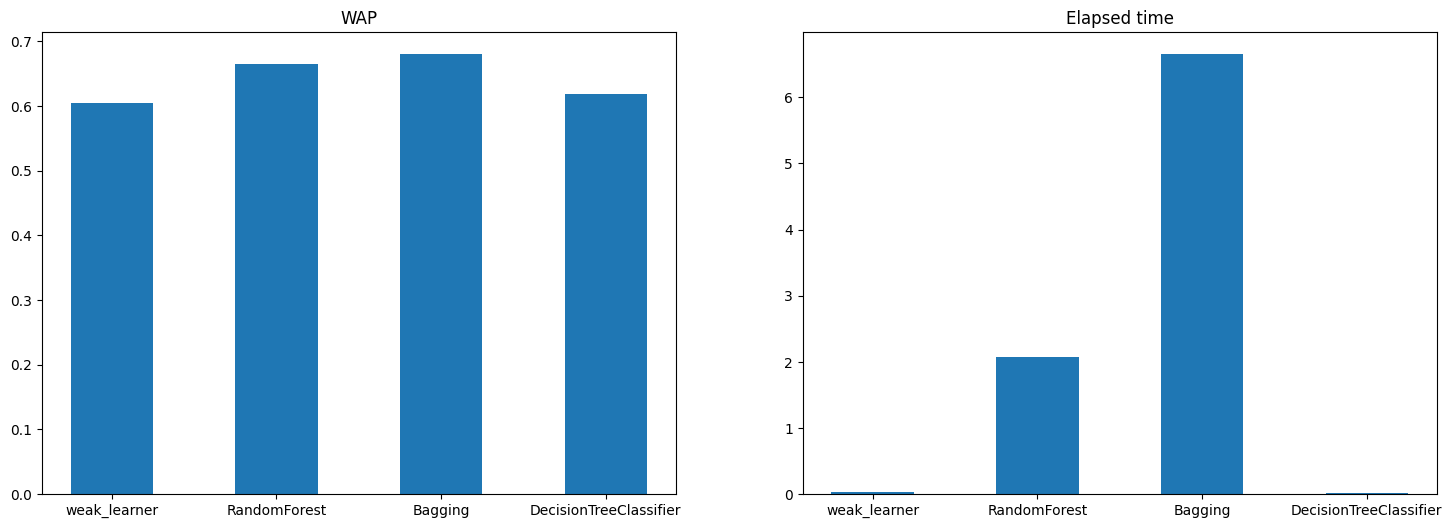

In [288]:
# create a handler for ensemble_test, use the created handler for fitting different models.
ensemble_handler = Evaluator(house_prices)
ensemble_handler.evaluate_model(get_weak_learner(), 'weak_learner')
# Workspace 2.11.a
# TODO Add multiple instances of the ensemble methods. Plot and compare their performance
# You can also add best tree from problem 3
#BEGIN
ensemble_handler.evaluate_model(RandomForest(300, sample_ratio=0.7, features_ratio=0.1), 'RandomForest')
ensemble_handler.evaluate_model(BaggingEnsemble(300, 0.9), 'Bagging')
ensemble_handler.evaluate_model(DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.1), 'DecisionTreeClassifier')

ensemble_handler.print_results()
ensemble_handler.plot_metrics()

#END


#END

#### Write-up 2.11.b
#BEGIN

The best weighted average precision was Bagging with a n_estimator of 300 and a WAP of $0.68$. Each ensemble method gets about the same WAP if you change their hypterparamters.
#END

### Problem 3: Multi-class AdaBoost (Bonus) [7 points]

There are different methods of boosting, but we'll focus in this problem on Adaptive Boosting (AdaBoost).
The logic of AdaBoost is to "push" each new learner to give more importance to previously misclassified data. We present
below the multiclass variant of AdaBoost [SAMME](https://web.stanford.edu/~hastie/Papers/samme.pdf). We denote $K$ the number of classes.

AdaBoost is performed by increasing the weights of misclassified samples after each iteration:
- Input: m samples $(X_i, y_i)_{i\in [m]}$, number of boosting rounds $N$
- Start with equal samples weights $W = (w_i), $ where   $w_i = \frac{1}{\texttt{n_samples}}$
- at round j:
    - Train estimator $h_j$ using current weights $W$
    - Get the predicted $(\hat{y}_i)$ on the training data using $h_j$
    - Find the weighted error rate $\epsilon_j$ using $W$: $\epsilon_j=\frac{\sum_i w_i \Delta(\hat{y}_i, y_i)}{\sum_i w_i}$
    - Choose $\alpha_j = \log \frac{1-\epsilon_j}{\epsilon_j} + \log(K-1)$
    - Update $W$ using: $w_i \leftarrow w_i \exp(\alpha_j \Delta(\hat{y_i}, y_i)) $
    - Normalize $W$ to have sum 1
- Global estimator is $H = \sum_j \alpha_j h_j$,

the $\Delta$ function equals to 1 when the two argument are different, 0 otherwise.

To understand how we implement $H$, imaging we have two classes, and we boosted for 3 rounds to get $(h_1, h_2, h_3)$,
with weights $(\alpha_1, \alpha_2, \alpha_3)$. When we want to predict the label of sample $x$, we get $(h_1(x), h_2(x), h_3(x)) = (0,1,0)$.

In this case, label $0$ gets a weight $\alpha_1+\alpha_2$, while class $1$ get weight $\alpha_2$. The predicted class is the one with
the largest weight (1 if $\alpha_2 > \alpha_1 + \alpha_3$, 0 otherwise)

<br>

**Q3.1 (Bonus)** [3 points] Complete `fit` by building `n_estimators` of DecisionTreeClassifier, each trained on the same data but with different samples weights as detailed in the algorithm. Keep track of $(\alpha_i)$

_Hint: our weak learner (DecisionTreeClassifier) can take an argument `sample_weight` when calling the `fit` method, you'll have to use it to provide the weights $W$_


**Q3.2 (Bonus)** [3 points] Complete `predict` method: it should handle multi-class labels, this is slighlty different from the binary case seen in the hands on.

Note: Notice that if the estimator is consistent (0 error rate on the training set), AdaBoost $\alpha_j$ are no longer defined. That's why this method requires a **weak** learner.

In [267]:
class AdaBoost(BaggingEnsemble):

    def __init__(self, n_estimators):
        """

        Args:
            n_estimators:
        """
        super(AdaBoost, self).__init__(n_estimators)
        self.num_classes = None
        self.alphas = []

    def fit(self, X_train, y_train):
        self.estimators = []
        self.alphas = []
        self.num_classes = np.unique(y_train).shape[0]  # K in the algorithm
        weights = np.ones(len(X_train)) / len(X_train)  # W in the algorithm
        # Workspace 3.1
        # TODO: Implement Multiclass Adaboost and keep track of the alpha_j
        #BEGIN

        for _ in range(self.n_estimators):

            estimator = get_weak_learner()
            estimator.fit(X_train, y_train, sample_weight=weights)
            self.estimators.append(estimator)

            predictions = estimator.predict(X_train)

            misclassified = predictions != y_train
            epsilon_j = np.sum(weights[misclassified]) / np.sum(weights)


            alpha_j = np.log((1 - epsilon_j) / (epsilon_j + 1e-10)) + np.log(self.num_classes - 1)
            self.alphas.append(alpha_j)


            weights *= np.exp(alpha_j * misclassified * 2 - 1)
            weights /= np.sum(weights)

        #END

    def predict(self, X_test):
        '''
        get the labels returned by the global estimator defined as H
        the predicted label is the one that accumulates the largest sum of alphas
        '''
        # y_hat is one-hot encoding of the multi-class labels
        answer = 0
        # Workspace 3.2
        #BEGIN
        num_samples = X_test.shape[0]
        class_scores = np.zeros((num_samples, self.num_classes))

        for estimator, alpha in zip(self.estimators, self.alphas):
            predictions = estimator.predict(X_test)
            for i in range(num_samples):
                class_scores[i, predictions[i]] += alpha
        answer = np.argmax(class_scores, axis=1)
        #END
        return answer

In [268]:
ensemble_handler.evaluate_model(AdaBoost(40), 'AdaBoost')
ensemble_handler.print_results()

                    Model       WAP  Execution time
2                 Bagging  0.661866        0.297356
1            RandomForest  0.661180        0.676038
4                AdaBoost  0.620713        0.884324
3  DecisionTreeClassifier  0.618656        0.033236
0            weak_learner  0.604252        0.050642


#####  **Comparison**

- **(Bonus)**  Q3.3 [1 point] Run the same comparison as in 2.11 including AdaBoost, and write up your findings below.

                    Model       WAP  Execution time
4                AdaBoost  0.747599       23.398002
2                 Bagging  0.680384        1.978947
1            RandomForest  0.658436        0.672787
3  DecisionTreeClassifier  0.618656        0.023083
0            weak_learner  0.604252        0.038154


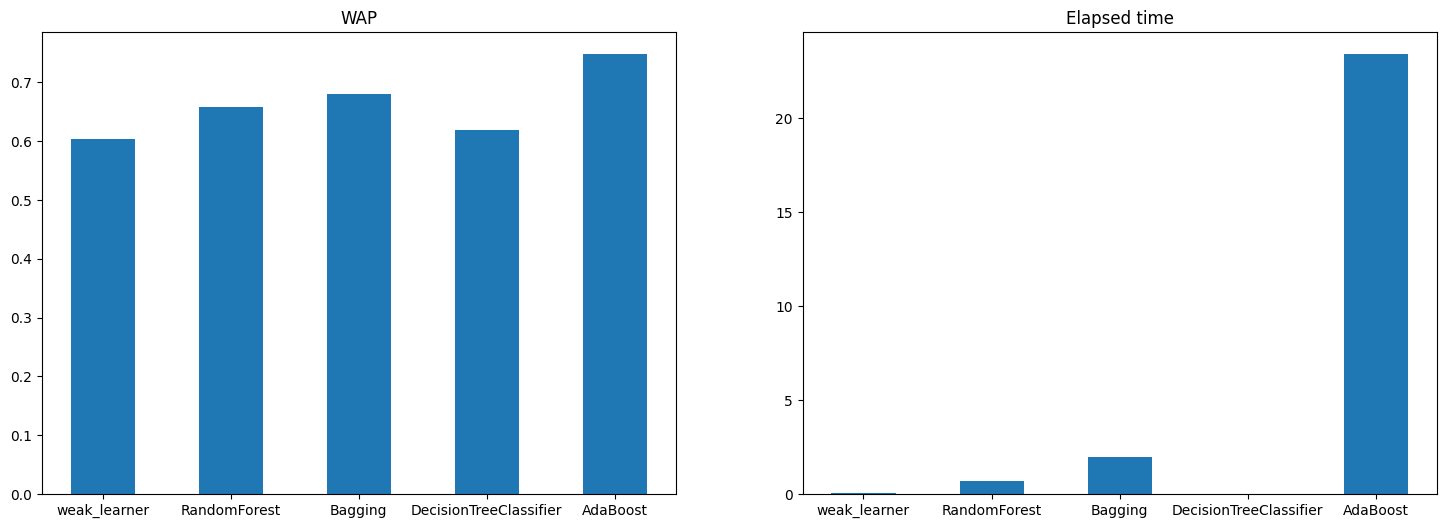

In [283]:
# create a handler for ensemble_test, use the created handler for fitting different models.
ensemble_handler = Evaluator(house_prices)
ensemble_handler.evaluate_model(get_weak_learner(), 'weak_learner')
# Workspace 3.3.a
# TODO Add multiple instances of the ensemble methods. Plot and compare their performance
#BEGIN
ensemble_handler.evaluate_model(RandomForest(100, sample_ratio=0.7, features_ratio=0.1), 'RandomForest')
ensemble_handler.evaluate_model(BaggingEnsemble(100, 0.9), 'Bagging')
ensemble_handler.evaluate_model(DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.1), 'DecisionTreeClassifier')
ensemble_handler.evaluate_model(AdaBoost(500), 'AdaBoost')

ensemble_handler.print_results()
ensemble_handler.plot_metrics()

#END

#### Write-up 3.3.b
#BEGIN

The best weighted average precision was $0.75$ from AdaBoost with a n_estimator of $500$.
#END